In [24]:
from scipy.integrate import quad
from scipy.fft import fft, fftfreq
from math import pi, sin, cos
import matplotlib.pyplot as plt
import numpy as np
import sympy as smp

This is based upon the video series https://www.youtube.com/playlist?list=PLB24BC7956EE040CD

The formula to calculate the fourier coefficients is basically the following:
$$ C_k = \int_0^1 e^{(-2 \pi i k t)} f(t) dt $$

In [2]:
class Fourier:
    def __init__(self, fn):
        self.fn = fn

    def ck(self,k):
        def f_real(t):
            res = self.fn(t)*cos(-2*pi*k*t)
            return res
        def f_imag(t):
            res = self.fn(t)*sin(-2*pi*k*t)
            return res
            
        realpart = quad(f_real, 0, 1, limit=100)[0]

        imagpart = quad(f_imag, 0, 1, limit=100)[0]
        return complex(realpart, imagpart)
    def ck2(self, k):
        if k == 0:
            return self.ck(0).real
        else:
            result = self.ck(k) + self.ck(-k).conjugate()
            #print ('**',k, self.ck(k), self.ck(-k))
            return result
        
    def freq(self, N):
        xvals = []
        yvals = []
        for k in range(0, N+1):
            result = self.ck2(k)
            xvals.append(k)
            yvals.append(result)

        return (xvals, yvals)
    
    def plot_frequencies(self, harmonics=40):
        xvals, yvals = self.freq(harmonics)
        yr = list(map(lambda x: x.real, yvals))
        yi = list(map(lambda x: x.imag, yvals))
        fig, ax = plt.subplots()
        ax.bar(xvals, yr, color='orange', label='even')
        xvals2 = list(map(lambda x: x+.5, xvals))
        ax.bar(xvals2, yi, color='blue', label='odd')
        ax.legend()
        ax.grid()
        plt.show()
        
    def plot_reconstructions(self, max_harmonics):
        cols = 3
        rows = 2

        fig, axs = plt.subplots(rows, cols, squeeze=True)
        fig.set_size_inches(12,8)
        #print (axs)
        #harmonics = [4,6,10,16,30, 60]
        for idx1 in range(0, rows):
            for idx2 in range(0, cols):

                axs[idx1][idx2].grid()
                trange = np.linspace(0,4, num=400)
                yrange = np.zeros_like(trange)

                h = max_harmonics.pop()
                xvals, yvals = self.freq(h)
                yr = list(map(lambda x: x.real, yvals))
                yi = list(map(lambda x: x.imag, yvals))
                for ii, t in enumerate(trange):

                    for k in range(0, h):
                        yrange[ii] += yi[k]*sin(2*pi*k*t) + yr[k]*cos(2*pi*k*t)
                axs[rows - idx1 -1][cols - idx2 -1].set_title("N = {}".format(h))        
                axs[rows - idx1 -1][cols - idx2 -1].plot(trange, yrange)

    def plot_single(self, harmonics=100):
        fig, ax = plt.subplots()
        trange = np.linspace(0,4, num=400)
        yrange = np.zeros_like(trange)
        xvals, yvals = self.freq(harmonics)
        yr = list(map(lambda x: x.real, yvals))
        yi = list(map(lambda x: x.imag, yvals))
        for ii, t in enumerate(trange):
            for k in range(0, harmonics):
                yrange[ii] += yi[k]*sin(2*pi*k*t) + yr[k]*cos(2*pi*k*t)
        ax.grid()
        plt.plot(trange, yrange)
        



We define a square wave

In [27]:
def fn(t):
    if t < 0.25 or t > .75:
        return 1
    else:
        return 0

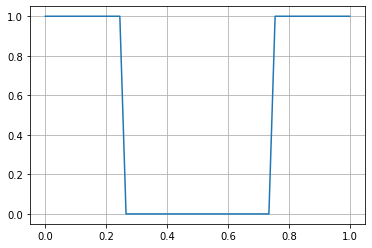

In [4]:
x = np.linspace(0,1)
ff = np.vectorize(fn)
y = ff(x)
ax = plt.gca()
ax.grid()
plt.plot(x,y)

In [5]:
fourier = Fourier(fn)

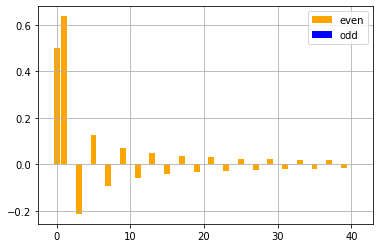

In [6]:
fourier.plot_frequencies()

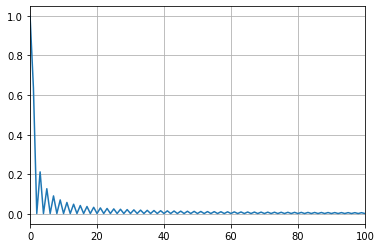

In [47]:
N = 1000
T = 1/1000
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.vectorize(fn)(x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.xlim(right=100)
plt.plot(xf, 2/N*np.abs(yf[0:N//2]))
#plt.plot(xf, 2/N*(yf[0:N//2]).imag)
plt.grid()
plt.show()

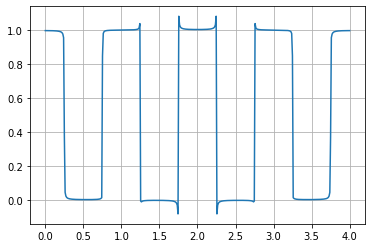

In [7]:
fourier.plot_single(harmonics=100)

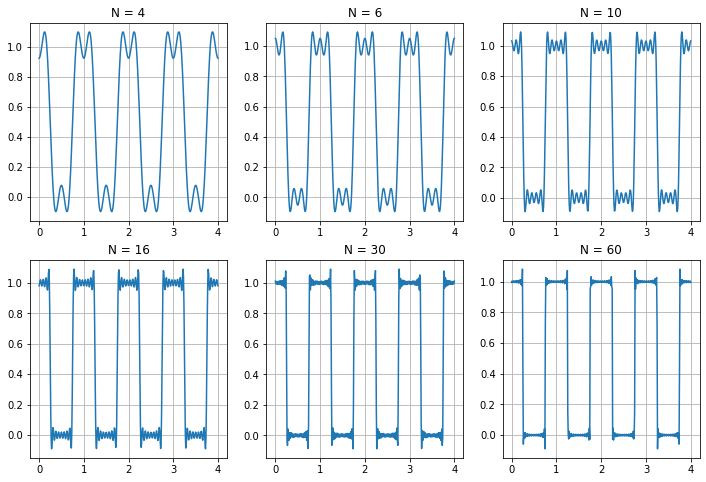

In [8]:
fourier.plot_reconstructions(max_harmonics = [4,6,10,16,30, 60])

To look at the same think analytically

In [9]:
k, T = smp.symbols("k T", integer=True)
t = smp.symbols("t", real=True)

In [10]:
smp.init_printing(use_latex=True)

In [11]:
eq = smp.exp(-2*smp.pi*smp.I * t * k)
eq

In [12]:
i1 = smp.integrate(eq, (t, 0, .25))
i1

⎧             -0.5⋅ⅈ⋅π⋅k           
⎪    ⅈ     ⅈ⋅ℯ                     
⎪- ───── + ─────────────  for k ≠ 0
⎨  2⋅π⋅k       2⋅π⋅k               
⎪                                  
⎪         0.25            otherwise
⎩                                  

In [13]:
i2 = smp.integrate(eq, (t, .75, 1))
i2

⎧           -1.5⋅ⅈ⋅π⋅k           
⎪  ⅈ     ⅈ⋅ℯ                     
⎪───── - ─────────────  for k ≠ 0
⎨2⋅π⋅k       2⋅π⋅k               
⎪                                
⎪        0.25           otherwise
⎩                                

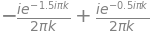

In [14]:
itotal = i1.args[0].args[0] + i2.args[0].args[0]
itotal

In [15]:
ff = smp.simplify(itotal.rewrite(smp.sin))
ff

In [16]:
from sympy.simplify.fu import TR9 # combine trig sums to products

In [17]:
TR9(ff)

The even integers inbetween have no effect as $ sin ( \frac{\pi ( 2k ) }{2}) = 0 $ and we also note that for odd k that the expression $ -(-1)^k $ is always equal to 1 so the only terms we need to consider is for when k is odd which we can represent by $ 2k - 1 $ and if we only consider those numbers then we have the following.

$$  - \frac{\left(-1\right)^{2k-1} \sin{\left(\frac{\pi (2k-1)}{2} \right)}}{\pi (2k-1)} $$

which should simplify to:

$$ C_{2k-1}= \frac{(-1)^{k-1} }{\pi (2k - 1)} $$

when k is odd and zero otherwise.

(**Note:**  This yields only half the value of what we expect on the frequency distribution because we have to sum up both sides of $C_k$ and $C_{-k}$ which doubles the value.)

Now lets look at a function without jump discontinuities but has discontinuities in the first derivative.

In [18]:
def fn(t):
    if t < 0.5:
        return 2*t
    else:
        return 1-2*(t-.5)

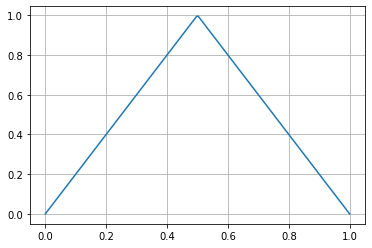

In [19]:
x = np.linspace(0,1, num=200)
ff = np.vectorize(fn)
y = ff(x)
ax = plt.gca()
ax.grid()
plt.plot(x,y)

In [20]:
fourier = Fourier(fn)

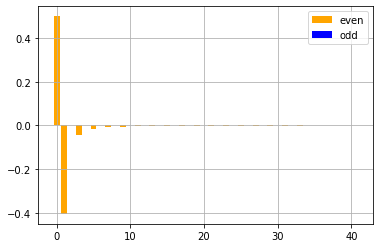

In [21]:
fourier.plot_frequencies()

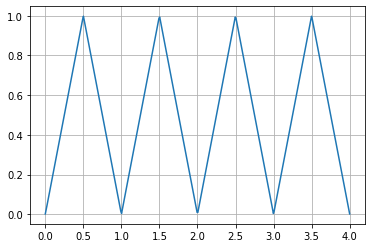

In [22]:
fourier.plot_single()

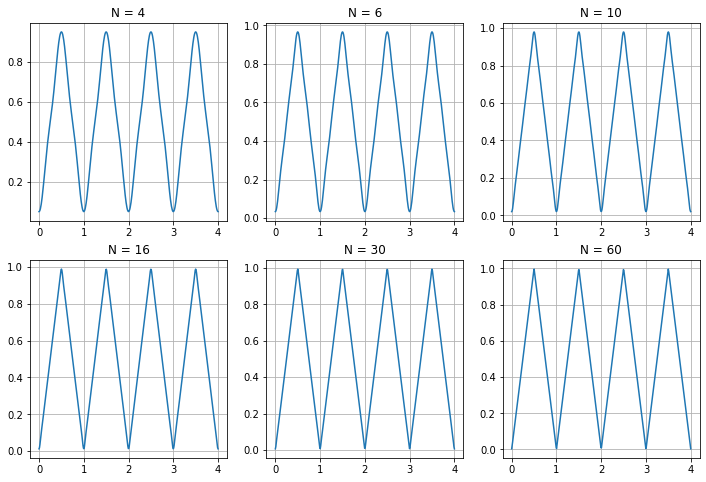

In [23]:
fourier.plot_reconstructions(max_harmonics = [4,6,10,16,30, 60])

I might look at if I can cirumvent Gibbs phenomena for a square wave by removing the jump discontinuities and replacing them with very steep, yet finite, slope.